In [1]:
import pandas as pd
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [2]:
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('english')

[nltk_data] Downloading package stopwords to C:\Users\MD. AQUIB
[nltk_data]     AZMI\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
eval_df = pd.read_csv('train_en.tsv', delimiter='\t', encoding='utf-8')

In [4]:
# Keep only relevant columns
eval_df = eval_df[['text', 'HS']]

In [5]:
eval_df.head()

,text,HS
0,"Hurray, saving us $$$ in so many ways @potus @...",1
1,Why would young fighting age men be the vast m...,1
2,@KamalaHarris Illegals Dump their Kids at the ...,1
3,NY Times: 'Nearly All White' States Pose 'an A...,0
4,Orban in Brussels: European leaders are ignori...,0


In [6]:
eval_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    9000 non-null   object
 1   HS      9000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 140.8+ KB


In [7]:
eval_df.shape

(9000, 2)

In [11]:
# Clean tweets
def clean_tweet(text):
    text = str(text).lower()
    text = re.sub(r'@[\w_]+', '', text)
    text = re.sub(r'https?://\S+', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

eval_df['text'] = eval_df['text'].apply(clean_tweet)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(
    eval_df['text'], eval_df['HS'], test_size=0.2, random_state=42, stratify=eval_df['HS']
)

In [17]:
# TF-IDF vectorizer (unigrams + bigrams)
tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words=stop)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

In [18]:
nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)

MultinomialNB()

In [23]:
nb_preds = nb_model.predict(X_test_vec)

In [24]:
print("Accuracy:", round(accuracy_score(y_test, nb_preds), 4))

Accuracy: 0.7422


In [25]:
print("\nClassification Report:\n", classification_report(y_test, nb_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79      1043
           1       0.73      0.61      0.67       757

    accuracy                           0.74      1800
   macro avg       0.74      0.72      0.73      1800
weighted avg       0.74      0.74      0.74      1800



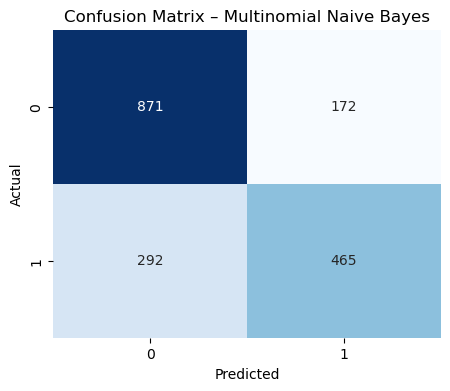

In [26]:
cm_nb = confusion_matrix(y_test, nb_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm_nb, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix – Multinomial Naive Bayes")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [27]:
# Reduce TF-IDF dimensionality (helps tree-based models)
svd = TruncatedSVD(n_components=300, random_state=42)
X_train_red = svd.fit_transform(X_train_vec)

In [28]:
X_test_red = svd.transform(X_test_vec)

In [29]:
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_red, y_train)

GradientBoostingClassifier(n_estimators=200, random_state=42)

In [30]:
gb_preds = gb_model.predict(X_test_red)

In [31]:
print("Accuracy:", round(accuracy_score(y_test, gb_preds), 4))

Accuracy: 0.755


In [32]:
print("\nClassification Report:\n", classification_report(y_test, gb_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.83      0.80      1043
           1       0.73      0.66      0.69       757

    accuracy                           0.76      1800
   macro avg       0.75      0.74      0.74      1800
weighted avg       0.75      0.76      0.75      1800



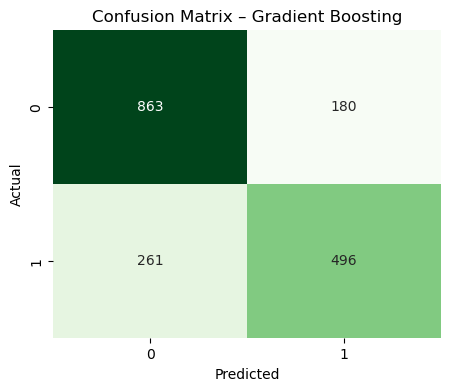

In [33]:
cm_gb = confusion_matrix(y_test, gb_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm_gb, annot=True, fmt='d', cmap='Greens', cbar=False)
plt.title("Confusion Matrix – Gradient Boosting")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [34]:
xgb_model = XGBClassifier(
    n_estimators=250,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train_red, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=250,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [35]:
xgb_preds = xgb_model.predict(X_test_red)

In [36]:
print("Accuracy:", round(accuracy_score(y_test, xgb_preds), 4))

Accuracy: 0.7656


In [37]:
print("\nClassification Report:\n", classification_report(y_test, xgb_preds))


Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.83      0.80      1043
           1       0.74      0.68      0.71       757

    accuracy                           0.77      1800
   macro avg       0.76      0.75      0.76      1800
weighted avg       0.76      0.77      0.76      1800



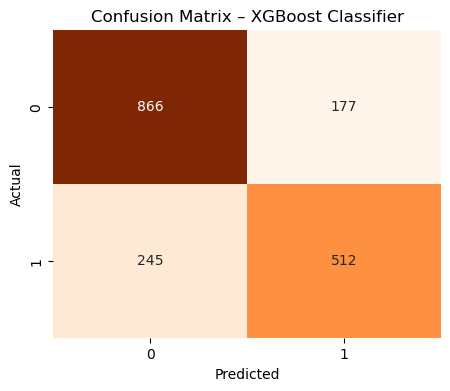

In [38]:
cm_xgb = confusion_matrix(y_test, xgb_preds)
plt.figure(figsize=(5,4))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Oranges', cbar=False)
plt.title("Confusion Matrix – XGBoost Classifier")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()